In [10]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2

## Prepare data

In [2]:
# Define the data to be used
DATASET = "../../datasets/dataset_to_delete/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]
        
        # Get the corresponding linear velocity
        linear_velocity = self.traversal_costs_frame.loc[idx, "linear_velocity"]

        return image, traversal_cost, traversability_label, linear_velocity

In [3]:
def compute_mean_std(images_directory, traversal_costs_file):
    """Compute the mean and standard deviation of the dataset

    Args:
        images_directory (string): Directory with all the images
        traversal_costs_file (string): Name of the csv file which contains
        images index and their associated traversal cost

    Returns:
        torch::Tensor: Mean and standard deviation of the dataset
    """
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
    
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform=transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(3)
    second_moment = torch.empty(3)

    for images, traversal_costs, traversability_labels, linear_velocity in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [4]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.3125, 0.3266, 0.2356]) tensor([0.1109, 0.0976, 0.1078])


In [5]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225]
        mean=mean,
        std=std
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225]
        mean=mean,
        std=std
    ),
])


# # Create a Dataset instance for our training data
# data = TraversabilityDataset(
#     traversal_costs_file=DATASET+"traversal_costs.csv",
#     images_directory=DATASET+"images",
#     transform=train_transform
# )

# # Split our training dataset into a training dataset and a validation dataset
# train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [6]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [7]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (695 samples)
15.0 % of the data for validation (149 samples)
15.0 % of the data for testing (150 samples)


In [8]:
print(len(train_loader.dataset))

695


## GPU?

In [9]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Model design and initialization

In [10]:
def resnet18(device=device):
    """Create a ResNet18 model with a fully-connected layer at the end.

    Args:
        device (string, optional): The device to use. Defaults to device.

    Returns:
        Model: The ResNet18 model
    """
    # Load the pre-trained ResNet model
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device=device)

    # Replace the last layer by a fully-connected one with N outputs
    # (N being the number of classes)
    resnet.fc = nn.Linear(resnet.fc.in_features, 10, device=device)

    # Initialize the last layer using Xavier initialization
    nn.init.xavier_uniform_(resnet.fc.weight)
    
    return resnet

In [78]:
class ResNet18WithNumericInput(nn.Module):
    
    def __init__(self, num_classes=10, num_input_features=1):
        
        super(ResNet18WithNumericInput, self).__init__()
        
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)
        
        self.dense_layer = nn.Linear(num_input_features, 210*70*3)
        
    
    def forward(self, x_img, x_dense):
        
        # FC layer to convert the numeric input to the same shape as the
        # activation map
        x_dense = self.dense_layer(x_dense)
        x_dense = x_dense.view(-1, 3, 70, 210)
        
        # Element-wise product of the activation map and the main-
        # channel input
        x = x_img * x_dense
        
        # Forward pass through the ResNet18
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)
        
        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)
        
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(x.size(0), -1)
        x = self.resnet18.fc(x)
        
        return x

In [79]:
# Create a ResNet18 model
model = ResNet18WithNumericInput().to(device=device)

In [80]:
# Create dummy tensors
images = torch.randn(32, 3, 70, 210).to(device=device)  # (batch, time, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, time, features)

print(model(images, data).shape)

torch.Size([32, 10])


#### Visualize the model

In [96]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
images = images.to(device)
linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
linear_velocities.unsqueeze_(1)

tensorboard.add_graph(model, (images, linear_velocities))

# print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

[('resnet18.conv1.weight', torch.Size([64, 3, 7, 7])), ('resnet18.bn1.weight', torch.Size([64])), ('resnet18.bn1.bias', torch.Size([64])), ('resnet18.layer1.0.conv1.weight', torch.Size([64, 64, 3, 3])), ('resnet18.layer1.0.bn1.weight', torch.Size([64])), ('resnet18.layer1.0.bn1.bias', torch.Size([64])), ('resnet18.layer1.0.conv2.weight', torch.Size([64, 64, 3, 3])), ('resnet18.layer1.0.bn2.weight', torch.Size([64])), ('resnet18.layer1.0.bn2.bias', torch.Size([64])), ('resnet18.layer1.1.conv1.weight', torch.Size([64, 64, 3, 3])), ('resnet18.layer1.1.bn1.weight', torch.Size([64])), ('resnet18.layer1.1.bn1.bias', torch.Size([64])), ('resnet18.layer1.1.conv2.weight', torch.Size([64, 64, 3, 3])), ('resnet18.layer1.1.bn2.weight', torch.Size([64])), ('resnet18.layer1.1.bn2.bias', torch.Size([64])), ('resnet18.layer2.0.conv1.weight', torch.Size([128, 64, 3, 3])), ('resnet18.layer2.0.bn1.weight', torch.Size([128])), ('resnet18.layer2.0.bn1.bias', torch.Size([128])), ('resnet18.layer2.0.conv2.we

## Training and validation loops

In [97]:
def train(model, device, train_loader, optimizer, criterion_classification, criterion_regression, bins_midpoints, epoch):
    """Train the model for one epoch

    Args:
        model (Model): The model to train
        device (string): The device to use (cpu or cuda)
        train_loader (Dataloader): The training data loader
        optimizer (Optimizer): The optimizer to use
        criterion_classification (Loss): The classification loss to use
        criterion_regression (Loss): The regression loss to use
        bins_midpoints (ndarray): The midpoints of the bins used to discretize the traversal costs
        epoch (int): The current epoch

    Returns:
        double, double, double: The training loss, the training accuracy and the training regression loss
    """
    # Initialize the training loss and accuracy
    train_loss = 0.
    train_correct = 0
    train_regression_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, traversability_labels, linear_velocities in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        traversability_labels = traversability_labels.to(device)
        linear_velocities = linear_velocities.type(torch.float32).to(device)
        
        # Add a dimension to the linear velocities tensor
        linear_velocities.unsqueeze_(1)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversability_labels = model(images, linear_velocities)
        # predicted_traversal_scores = nn.Softmax(dim=1)(model(images))
        
        # Compute loss 
        loss = criterion_classification(predicted_traversability_labels, traversability_labels)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
        # Get the number of correct predictions
        train_correct += torch.sum(
            torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
            ).item()
        
        # Compute the expected traversal cost over the bins
        expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)
        
        # Compute and accumulate the batch loss
        train_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
    
    # Compute the losses and accuracies
    train_loss /= len(train_loader)
    train_accuracy = 100*train_correct/NB_TRAIN
    train_regression_loss /= len(train_loader)
        
    return train_loss, train_accuracy, train_regression_loss

In [98]:
def validate(model, device, val_loader, criterion_classification, criterion_regression, bins_midpoints, epoch):
    """Validate the model for one epoch

    Args:
        model (Model): The model to validate
        device (string): The device to use (cpu or cuda)
        val_loader (Dataloader): The validation data loader
        criterion_classification (Loss): The classification loss to use
        criterion_regression (Loss): The regression loss to use
        bins_midpoints (ndarray): The midpoints of the bins used to discretize the traversal costs
        epoch (int): The current epoch
        
    Returns:
        double, double, double: The validation loss, the validation accuracy and the validation regression loss
    """
    # Initialize the validation loss and accuracy
    val_loss = 0.
    val_correct = 0
    val_regression_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, traversability_labels, linear_velocities in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            traversability_labels = traversability_labels.to(device)
            linear_velocities = linear_velocities.type(torch.float32).to(device)
            
            # Add a dimension to the linear velocities tensor
            linear_velocities.unsqueeze_(1)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversability_labels = model(images, linear_velocities)
            # predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

            # Compute loss
            loss = criterion_classification(predicted_traversability_labels, traversability_labels)

            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
            # Get the number of correct predictions
            val_correct += torch.sum(
                torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
                ).item()
            
            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)

            # Compute and accumulate the batch loss
            val_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
        
    # Compute the losses and accuracies
    val_loss /= len(val_loader)
    val_accuracy = 100*val_correct/NB_VAL
    val_regression_loss /= len(val_loader)
    
    return val_loss, val_accuracy, val_regression_loss

In [99]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None], dtype=torch.float32, device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.resnet18.fc.parameters(), "lr": 1e-3},
],
    lr=1e-4, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 40

# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, NB_EPOCHS)
accuracy_values = torch.zeros(2, NB_EPOCHS)
regression_loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss, train_accuracy, train_regression_loss = train(model,
                                                              device,
                                                              train_loader,
                                                              optimizer,
                                                              criterion_classification,
                                                              criterion_regression,
                                                              bins_midpoints,
                                                              epoch)
    
    # Validation
    val_loss, val_accuracy, val_regression_loss = validate(model,
                                                           device,
                                                           val_loader,
                                                           criterion_classification,
                                                           criterion_regression,
                                                           bins_midpoints,
                                                           epoch) 
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    # Add the accuracies to TensorBoard
    tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
    tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
    # Add the regression losses to TensorBoard
    tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
    tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.38batch/s, batch_loss=1.26]


Train accuracy:  28.057553956834532
Validation accuracy:  36.241610738255034
Train regression loss:  0.0007785612556119942
Validation regression loss:  0.00021264605437096296


Epoch 1 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.35batch/s, batch_loss=1.24]


Train accuracy:  33.669064748201436
Validation accuracy:  40.939597315436245
Train regression loss:  0.00035445095091366684
Validation regression loss:  0.00021028454987158336


Epoch 2 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.30batch/s, batch_loss=1.4] 


Train accuracy:  32.37410071942446
Validation accuracy:  41.61073825503356
Train regression loss:  0.0003611755480438133
Validation regression loss:  0.00021649680200503118


Epoch 3 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.60batch/s, batch_loss=1.45]


Train accuracy:  36.402877697841724
Validation accuracy:  41.61073825503356
Train regression loss:  0.0003503523632411617
Validation regression loss:  0.00021048189247532004


Epoch 4 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.22batch/s, batch_loss=1.38]


Train accuracy:  33.52517985611511
Validation accuracy:  43.624161073825505
Train regression loss:  0.00034669108923033915
Validation regression loss:  0.00021160092894875092


Epoch 5 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.36batch/s, batch_loss=1.16]


Train accuracy:  38.84892086330935
Validation accuracy:  46.308724832214764
Train regression loss:  0.0003373763039178211
Validation regression loss:  0.0002050388120696447


Epoch 6 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.34batch/s, batch_loss=1.15]


Train accuracy:  38.992805755395686
Validation accuracy:  44.966442953020135
Train regression loss:  0.0003357113168717395
Validation regression loss:  0.00020603725957274712


Epoch 7 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.29batch/s, batch_loss=1.02]


Train accuracy:  41.29496402877698
Validation accuracy:  44.966442953020135
Train regression loss:  0.00032458276359753277
Validation regression loss:  0.0002001443413878066


Epoch 8 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.26batch/s, batch_loss=1.15]


Train accuracy:  40.57553956834533
Validation accuracy:  46.308724832214764
Train regression loss:  0.00032864759660996797
Validation regression loss:  0.00019722373065345788


Epoch 9 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.22batch/s, batch_loss=1.27]


Train accuracy:  38.992805755395686
Validation accuracy:  48.993288590604024
Train regression loss:  0.0003417490416213731
Validation regression loss:  0.00019429122099546496


Epoch 10 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.25batch/s, batch_loss=1.54]


Train accuracy:  39.856115107913666
Validation accuracy:  51.006711409395976
Train regression loss:  0.0003229698082560123
Validation regression loss:  0.00019072982959673817


Epoch 11 [val]: 100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, batch_loss=1.17]


Train accuracy:  39.13669064748201
Validation accuracy:  49.66442953020134
Train regression loss:  0.00031632924902882026
Validation regression loss:  0.00019313280137016396


Epoch 12 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.26batch/s, batch_loss=1.58]


Train accuracy:  41.8705035971223
Validation accuracy:  42.281879194630875
Train regression loss:  0.000320774764076567
Validation regression loss:  0.00022029357142265741


Epoch 13 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.27batch/s, batch_loss=1.76] 


Train accuracy:  41.58273381294964
Validation accuracy:  51.006711409395976
Train regression loss:  0.0003218624691015646
Validation regression loss:  0.00021342649132993376


Epoch 14 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.41batch/s, batch_loss=1.32]


Train accuracy:  41.29496402877698
Validation accuracy:  51.006711409395976
Train regression loss:  0.0003099951298150767
Validation regression loss:  0.00019471668190081175


Epoch 15 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.29batch/s, batch_loss=1.31]


Train accuracy:  38.992805755395686
Validation accuracy:  47.651006711409394
Train regression loss:  0.00031786701956357575
Validation regression loss:  0.00019956017655423482


Epoch 16 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.21batch/s, batch_loss=1.31]


Train accuracy:  38.70503597122302
Validation accuracy:  39.59731543624161
Train regression loss:  0.00031682276619388153
Validation regression loss:  0.000184997012450076


Epoch 17 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.27batch/s, batch_loss=1.28]


Train accuracy:  40.143884892086334
Validation accuracy:  47.651006711409394
Train regression loss:  0.000320067402407704
Validation regression loss:  0.00020384455553744104


Epoch 18 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.25batch/s, batch_loss=1.41]


Train accuracy:  43.7410071942446
Validation accuracy:  49.66442953020134
Train regression loss:  0.00032153342262759014
Validation regression loss:  0.00021375970740215906


Epoch 19 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.33batch/s, batch_loss=1.1] 


Train accuracy:  41.43884892086331
Validation accuracy:  47.651006711409394
Train regression loss:  0.0003055054314424646
Validation regression loss:  0.00019547179980587866


Epoch 20 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.04batch/s, batch_loss=1.44]


Train accuracy:  39.280575539568346
Validation accuracy:  48.32214765100671
Train regression loss:  0.00029542554592558256
Validation regression loss:  0.0002028279449625582


Epoch 21 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.14batch/s, batch_loss=1.21]


Train accuracy:  40.57553956834533
Validation accuracy:  51.67785234899329
Train regression loss:  0.0002921089091354793
Validation regression loss:  0.000189046079956919


Epoch 22 [val]: 100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, batch_loss=1.34]


Train accuracy:  38.84892086330935
Validation accuracy:  38.92617449664429
Train regression loss:  0.00030638858569428885
Validation regression loss:  0.00018649048857600012


Epoch 23 [val]: 100%|██████████| 5/5 [00:01<00:00,  3.70batch/s, batch_loss=1.37]


Train accuracy:  41.15107913669065
Validation accuracy:  44.966442953020135
Train regression loss:  0.00029814428685702937
Validation regression loss:  0.0002006805017178907


Epoch 24 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.40batch/s, batch_loss=1.29]


Train accuracy:  43.45323741007194
Validation accuracy:  53.02013422818792
Train regression loss:  0.00029610057013716023
Validation regression loss:  0.00018371329438685821


Epoch 25 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.18batch/s, batch_loss=1.36]


Train accuracy:  44.74820143884892
Validation accuracy:  53.691275167785236
Train regression loss:  0.00028528477522501966
Validation regression loss:  0.00021344491550503086


Epoch 26 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.47batch/s, batch_loss=1.23]


Train accuracy:  43.02158273381295
Validation accuracy:  48.993288590604024
Train regression loss:  0.00029664851059275026
Validation regression loss:  0.00021804391698378037


Epoch 27 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.45batch/s, batch_loss=1.2] 


Train accuracy:  42.302158273381295
Validation accuracy:  47.651006711409394
Train regression loss:  0.000288521195315769
Validation regression loss:  0.00019600213771700362


Epoch 28 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.33batch/s, batch_loss=1.19]


Train accuracy:  40.431654676258994
Validation accuracy:  42.281879194630875
Train regression loss:  0.00027528604367767353
Validation regression loss:  0.00017758723192998947


Epoch 29 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.32batch/s, batch_loss=1.2] 


Train accuracy:  45.17985611510792
Validation accuracy:  45.63758389261745
Train regression loss:  0.00030273282265392247
Validation regression loss:  0.0001807296231749441


Epoch 30 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.33batch/s, batch_loss=1.2] 


Train accuracy:  45.03597122302158
Validation accuracy:  48.993288590604024
Train regression loss:  0.0002803382559824033
Validation regression loss:  0.0001800335916145428


Epoch 31 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.34batch/s, batch_loss=1.25]


Train accuracy:  43.884892086330936
Validation accuracy:  50.33557046979866
Train regression loss:  0.0002778633841982606
Validation regression loss:  0.0001893281585772608


Epoch 32 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.27batch/s, batch_loss=1.57]


Train accuracy:  43.45323741007194
Validation accuracy:  46.308724832214764
Train regression loss:  0.00026820132684189147
Validation regression loss:  0.0002047158327936588


Epoch 33 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.53batch/s, batch_loss=1.03]


Train accuracy:  45.32374100719424
Validation accuracy:  39.59731543624161
Train regression loss:  0.00027616929176101524
Validation regression loss:  0.00017044398132634578


Epoch 34 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.42batch/s, batch_loss=1.21]


Train accuracy:  42.73381294964029
Validation accuracy:  45.63758389261745
Train regression loss:  0.00025767391533846316
Validation regression loss:  0.00017038558893129658


Epoch 35 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.37batch/s, batch_loss=1.29] 


Train accuracy:  45.03597122302158
Validation accuracy:  49.66442953020134
Train regression loss:  0.000273816811968055
Validation regression loss:  0.000185070912428856


Epoch 36 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.23batch/s, batch_loss=1.12]


Train accuracy:  44.31654676258993
Validation accuracy:  46.308724832214764
Train regression loss:  0.0002771266068054868
Validation regression loss:  0.00018270145611789198


Epoch 37 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.41batch/s, batch_loss=1.26]


Train accuracy:  45.03597122302158
Validation accuracy:  48.32214765100671
Train regression loss:  0.0002751637723206044
Validation regression loss:  0.00018116001372879613


Epoch 38 [val]: 100%|██████████| 5/5 [00:01<00:00,  3.82batch/s, batch_loss=1.68]


Train accuracy:  44.460431654676256
Validation accuracy:  50.33557046979866
Train regression loss:  0.00026177470055968935
Validation regression loss:  0.00022165562042005468


Epoch 39 [val]: 100%|██████████| 5/5 [00:01<00:00,  4.21batch/s, batch_loss=1.11]

Train accuracy:  44.172661870503596
Validation accuracy:  53.02013422818792
Train regression loss:  0.0002473966588879977
Validation regression loss:  0.00019133026293886653


### Visualization

Text(0.5, 0, 'Epoch')

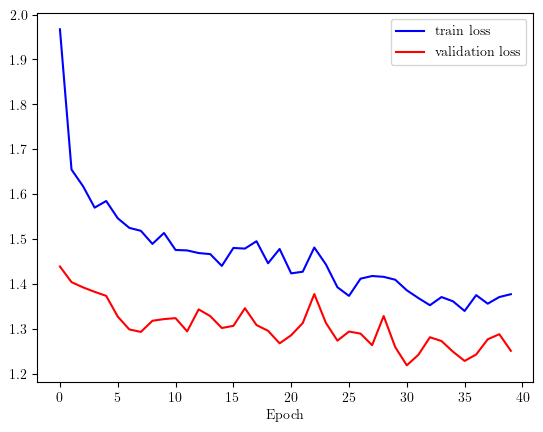

In [100]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

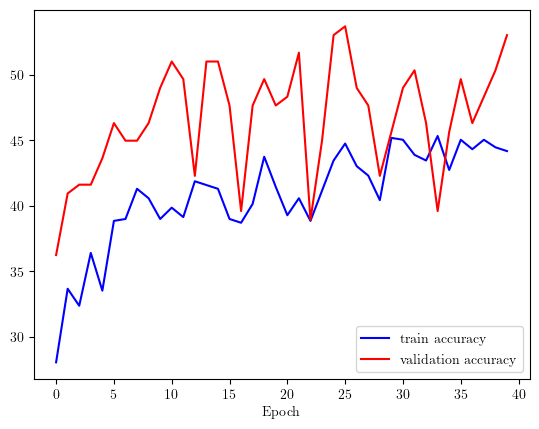

In [101]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

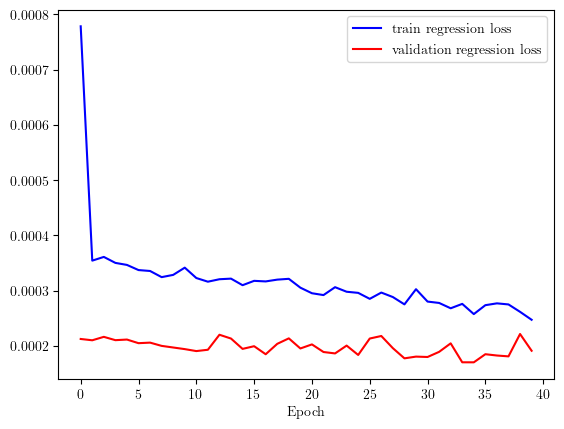

In [102]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Uncertainty functions

In [103]:
def shannon_entropy(p):
    """
    Apply the Shannon entropy function to a probability distribution
    """
    return -torch.sum(p*torch.log(p), dim=1)

def least_confidence(p):
    """
    Apply the least confidence function to a probability distribution
    """
    return 1 - torch.max(p, dim=1)[0]

def confidence_margin(p):
    """
    Apply the margin sampling function to a probability distribution
    """
    sorted_p, _ = torch.sort(p, dim=1, descending=True)
    return 1 - (sorted_p[:, 0] - sorted_p[:, 1])


#### Regression error function

In [104]:
def squared_error(predicted_costs, true_costs):
    """
    Apply the squared error function to a predicted and true traversal cost
    """
    return (predicted_costs - true_costs)**2

#### Test function

In [105]:
def test(model, device, test_loader, criterion_classification, criterion_regression, bins_midpoints, uncertainty_function):
    """Test the model on the test set

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        test_loader (Dataloader): The dataloader for the test set
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty

    Returns:
        double, double, double, list, list: The average loss, the accuracy, the regression loss,
        the list of the uncertainties, the list of regression losses
    """
    # Testing
    test_loss = 0.
    test_correct = 0
    test_regression_loss = 0.

    # Configure the model for testing
    model.eval()

    test_regression_losses = []
    uncertainties = []

    with torch.no_grad():
        # Loop over the testing batches
        for images, traversal_costs, traversability_labels, linear_velocities in test_loader:

            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            traversability_labels = traversability_labels.to(device)
            linear_velocities = linear_velocities.type(torch.float32).to(device)

            # Add a dimension to the linear velocities tensor
            linear_velocities.unsqueeze_(1)
            
            # Perform forward pass
            predicted_traversability_labels = model(images, linear_velocities)

            # Compute loss
            loss = criterion_classification(predicted_traversability_labels, traversability_labels)
            
            # Accumulate batch loss to average of the entire testing set
            test_loss += loss.item()

            # Get the number of correct predictions
            test_correct += torch.sum(
                torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
                ).item()

            # Apply the softmax function to the predicted traversability labels
            probabilities = nn.Softmax(dim=1)(predicted_traversability_labels)

            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(probabilities, bins_midpoints)
            
            # Compute and accumulate the batch loss
            test_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()

            # Compute the loss for each sample
            test_regression_losses.append(squared_error(expected_traversal_costs[:, 0], traversal_costs).to("cpu"))
            
            # Compute the uncertainty
            uncertainties.append(uncertainty_function(probabilities).to("cpu"))

    # Compute the loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100*test_correct/NB_TEST
    
    # Compute the regression loss
    test_regression_loss /= len(test_loader)
   
    return test_loss, test_accuracy, test_regression_loss, test_regression_losses, uncertainties

#### Testing the model

In [106]:
# Set the uncertainty function
uncertainty_function = shannon_entropy

# Test the model
_, test_accuracy, test_regression_loss, test_regression_losses, uncertainties = test(model,
                                                                                     device,
                                                                                     test_loader,
                                                                                     criterion_classification,
                                                                                     criterion_regression,
                                                                                     bins_midpoints,
                                                                                     uncertainty_function)

print("Test accuracy: ", test_accuracy)
print("Regression loss: ", test_regression_loss)

Test accuracy:  42.0
Regression loss:  0.0003275089442732589


## Save model parameters

In [25]:
# Save the model parameters
# torch.save(model.state_dict(), "resnet18_.params")

## Assessing the relevance of the uncertainty

In [118]:
def uncertainty_relevance(model,
                          device,
                          criterion_classification,
                          criterion_regression,
                          bins_midpoints,
                          uncertainty_function,
                          test_set,
                          test_regression_loss,
                          test_regression_losses,
                          uncertainties,
                          nb_samples=len(test_set)):
    """Compute the regression losses after successive removal of the samples with the highest loss and uncertainty

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty
        test_set (Dataset): The test set
        test_regression_loss (double): The regression loss on the test set
        test_regression_losses (list): The list of the regression losses for each sample
        uncertainties (list): The list of the uncertainties for each sample
        nb_samples (int, optional): The number of samples in the test set. Defaults to len(test_set).

    Returns:
        list, list: The list of the regression losses after successive removal of the samples with the highest loss,
        the list of the regression losses after successive removal of the samples with the highest uncertainty
    """
    # Create lists to store the test losses
    test_losses_loss = [test_regression_loss]
    test_losses_uncertainty = [test_regression_loss]
    
    # Concatenate the regression losses and convert to numpy array
    test_regression_losses = torch.cat(test_regression_losses, dim=0).numpy()

    # Concatenate the uncertainties and convert to numpy array
    uncertainties = torch.cat(uncertainties, dim=0).numpy()

    # Loop over the different percentages of samples to keep
    for i in range(1, 10):

        # Calculate the number of samples to keep
        nb_samples_to_keep = int((1 - i*0.1)*nb_samples)
        # Calculate the indices of the samples with the lowest losses
        indices_to_keep_loss = test_regression_losses.argsort()[:nb_samples_to_keep]
        # Calculate the indices of the samples with the lowest uncertainties
        indices_to_keep_uncertainty = uncertainties.argsort()[:nb_samples_to_keep]
        
        if i == 1:
            test_set_display = Subset(test_set, indices=uncertainties.argsort()[nb_samples_to_keep:])
            
            for tensor, tcost, tclass, vel in test_set_display:
                # De-normalize the normalized tensor
                tensor_denormalized = transforms.Compose([
                    transforms.Normalize(
                        mean=[0., 0., 0.],
                        std=1/std
                        ),
                    transforms.Normalize(
                        mean=-mean,
                        std=[1., 1., 1.]
                        ),
                    ])(tensor)

                # Convert the tensor to a PIL Image
                image_denormalized = transforms.ToPILImage()(tensor_denormalized)
                
                plt.imshow(image_denormalized)
                plt.title("De-normalized image")
                
                # print(type(image))
                # image = image.numpy().transpose(1, 2, 0)
                
                # cv2.imshow("Image", image)
                # cv2.waitKey()

        # Create a new test dataset without the samples with the largest losses
        test_set_loss = Subset(test_set, indices=indices_to_keep_loss)
        # Create a new test dataset without the samples with the largest uncertainties
        test_set_uncertainty = Subset(test_set, indices=indices_to_keep_uncertainty)

        # Create a new test dataloader without the samples with the largest losses
        test_loader_loss = DataLoader(test_set_loss,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=12,
                                      pin_memory=True,
                                      )
        # Create a new test dataloader without the samples with the largest uncertainties
        test_loader_uncertainty = DataLoader(test_set_uncertainty,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=12,
                                             pin_memory=True,
                                             )

        # Test the model on the new test dataset without the samples with the largest losses
        test_regression_loss_loss = test(model, 
                                         device,
                                         test_loader_loss,
                                         criterion_classification,
                                         criterion_regression,
                                         bins_midpoints,
                                         uncertainty_function)[2]
        # Test the model on the new test dataset without the samples with the largest uncertainties
        test_regression_loss_uncertainty = test(model,
                                                device,
                                                test_loader_uncertainty,
                                                criterion_classification,
                                                criterion_regression,
                                                bins_midpoints,
                                                uncertainty_function)[2]

        # Append the test loss to the list
        test_losses_loss.append(test_regression_loss_loss)
        test_losses_uncertainty.append(test_regression_loss_uncertainty)
        
    return test_losses_loss, test_losses_uncertainty

In [119]:
# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = uncertainty_relevance(model,
                                                                  device,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  uncertainty_function,
                                                                  test_set,
                                                                  test_regression_loss,
                                                                  test_regression_losses,
                                                                  uncertainties)

ValueError: too many values to unpack (expected 3)

#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

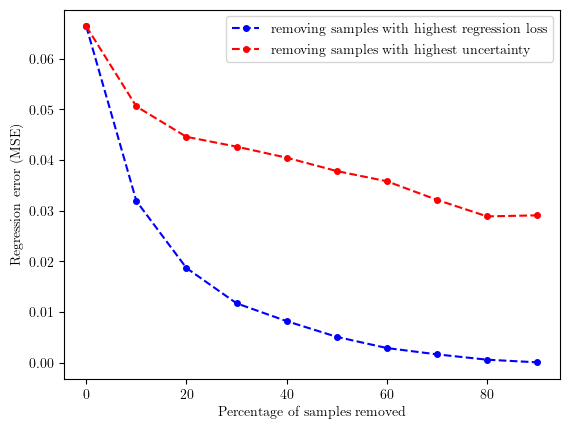

In [28]:
plt.plot(range(0, 100, 10), test_losses_loss, "bo--", label="removing samples with highest regression loss", markersize=4)
plt.plot(range(0, 100, 10), test_losses_uncertainty, "ro--", label="removing samples with highest uncertainty", markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")

### Ensemble learning

#### Training the models

In [113]:
# Create a list of models
nb_models = 3
some_models = [ResNet18WithNumericInput().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(), "lr": 1e-3},
    ],
        lr=1e-4, momentum=0.9, weight_decay=0.001)
    
    # Loop over the epochs
    for epoch in range(NB_EPOCHS):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

Training model 1/3


Epoch 39 [train]: 100%|██████████| 22/22 [00:02<00:00, 10.65batch/s, batch_loss=1.3] 


Training model 2/3


Epoch 39 [train]: 100%|██████████| 22/22 [00:01<00:00, 11.42batch/s, batch_loss=1.35]


Training model 3/3


Epoch 39 [train]: 100%|██████████| 22/22 [00:02<00:00, 10.96batch/s, batch_loss=1.17]


In [114]:
def test_models(models, device, test_loader, criterion_classification, criterion_regression, bins_midpoints, uncertainty_function):
    """Test the models on the test set

    Args:
        models (list): List of models to test
        device (string): The device to use for the computations
        test_loader (Dataloader): The dataloader for the test set
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty

    Returns:
        double, double, double, list, list: The average loss, the accuracy, the regression loss,
        the list of the uncertainties, the list of regression losses
    """
    # Testing
    test_regression_loss = 0.

    # Configure the models for testing
    for model in models:
        model.eval()

    test_regression_losses = []
    uncertainties = []

    with torch.no_grad():
        # Loop over the testing batches
        for images, traversal_costs, traversability_labels, linear_velocities in test_loader:

            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            linear_velocities = linear_velocities.type(torch.float32).to(device)
            
            # Add a dimension to the linear velocities tensor
            linear_velocities = linear_velocities.unsqueeze_(1)

            # expected_traversal_costs = torch.zeros(traversal_costs.shape[0], 1).to(device)
            
            # uncert = torch.zeros(traversal_costs.shape[0]).to(device)
            
            probabilities = torch.zeros(traversal_costs.shape[0], 10).to(device)
            
            exp_costs = torch.zeros(traversal_costs.shape[0], len(models)).to(device)
            
            # Perform forward pass
            for index, model in enumerate(models):
                
                predicted_traversability_labels = model(images, linear_velocities)

                # Apply the softmax function to the predicted traversability labels
                probabilities += nn.Softmax(dim=1)(predicted_traversability_labels)

                # Compute the expected traversal cost over the bins
                # expected_traversal_costs += torch.matmul(probabilities, bins_midpoints)
                
                # Compute the uncertainty
                # uncert += uncertainty_function(probabilities)
                
                exp_costs[:, index] = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)[:, 0]
            
            probabilities /= len(models)
            
            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(probabilities, bins_midpoints)
            
            variance = torch.var(exp_costs, dim=1)
            uncertainties.append(variance.to("cpu"))
            
            # uncertainties.append(uncertainty_function(probabilities).to("cpu"))
                
            # Compute and accumulate the batch loss
            test_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()

            # Compute the loss for each sample
            test_regression_losses.append(squared_error(expected_traversal_costs[:, 0], traversal_costs).to("cpu"))

    # Compute the regression loss
    test_regression_loss /= len(test_loader)
   
    return test_regression_loss, test_regression_losses, uncertainties

In [115]:
def uncertainty_relevance_models(models,
                          device,
                          criterion_classification,
                          criterion_regression,
                          bins_midpoints,
                          uncertainty_function,
                          test_set,
                          test_regression_loss,
                          test_regression_losses,
                          uncertainties,
                          nb_samples=len(test_set)):
    """Compute the regression losses after successive removal of the samples with the highest loss and uncertainty

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty
        test_set (Dataset): The test set
        test_regression_loss (double): The regression loss on the test set
        test_regression_losses (list): The list of the regression losses for each sample
        uncertainties (list): The list of the uncertainties for each sample
        nb_samples (int, optional): The number of samples in the test set. Defaults to len(test_set).

    Returns:
        list, list: The list of the regression losses after successive removal of the samples with the highest loss,
        the list of the regression losses after successive removal of the samples with the highest uncertainty
    """
    # Create lists to store the test losses
    test_losses_loss = [test_regression_loss]
    test_losses_uncertainty = [test_regression_loss]
    
    # Concatenate the regression losses and convert to numpy array
    test_regression_losses = torch.cat(test_regression_losses, dim=0).numpy()

    # Concatenate the uncertainties and convert to numpy array
    uncertainties = torch.cat(uncertainties, dim=0).numpy()

    # Loop over the different percentages of samples to keep
    for i in range(1, 10):

        # Calculate the number of samples to keep
        nb_samples_to_keep = int((1 - i*0.1)*nb_samples)
        # Calculate the indices of the samples with the lowest losses
        indices_to_keep_loss = test_regression_losses.argsort()[:nb_samples_to_keep]
        # Calculate the indices of the samples with the lowest uncertainties
        indices_to_keep_uncertainty = uncertainties.argsort()[:nb_samples_to_keep]

        # Create a new test dataset without the samples with the largest losses
        test_set_loss = Subset(test_set, indices=indices_to_keep_loss)
        # Create a new test dataset without the samples with the largest uncertainties
        test_set_uncertainty = Subset(test_set, indices=indices_to_keep_uncertainty)

        # Create a new test dataloader without the samples with the largest losses
        test_loader_loss = DataLoader(test_set_loss,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=12,
                                      pin_memory=True,
                                      )
        # Create a new test dataloader without the samples with the largest uncertainties
        test_loader_uncertainty = DataLoader(test_set_uncertainty,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=12,
                                             pin_memory=True,
                                             )

        # Test the model on the new test dataset without the samples with the largest losses
        test_regression_loss_loss = test_models(models, 
                                         device,
                                         test_loader_loss,
                                         criterion_classification,
                                         criterion_regression,
                                         bins_midpoints,
                                         uncertainty_function)[0]
        # Test the model on the new test dataset without the samples with the largest uncertainties
        test_regression_loss_uncertainty = test_models(models,
                                                device,
                                                test_loader_uncertainty,
                                                criterion_classification,
                                                criterion_regression,
                                                bins_midpoints,
                                                uncertainty_function)[0]
        
        # Append the test loss to the list
        test_losses_loss.append(test_regression_loss_loss)
        test_losses_uncertainty.append(test_regression_loss_uncertainty)
        
    return test_losses_loss, test_losses_uncertainty

In [116]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = shannon_entropy

# Loop over the models
# for i in range(nb_models):
    
    
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = uncertainty_relevance_models(some_models,
                                                                  device,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  uncertainty_function,
                                                                  test_set,
                                                                  test_regression_loss,
                                                                  test_regression_losses,
                                                                  uncertainties)

Test regression loss:  0.00031919827654147063


#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

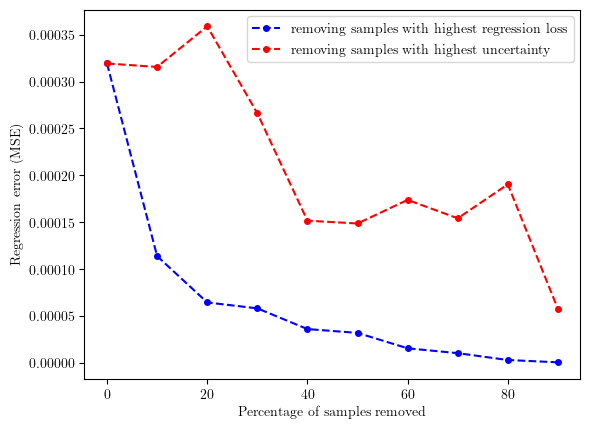

In [117]:
plt.plot(range(0, 100, 10), test_losses_loss, "bo--", label="removing samples with highest regression loss", markersize=4)
plt.plot(range(0, 100, 10), test_losses_uncertainty, "ro--", label="removing samples with highest uncertainty", markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")